# Project: Simulating Helicopter Operations in Upstate New York

## Installing Classes

In [3]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import scipy 
import scipy.stats as scs
from haversine import haversine
import matplotlib.pyplot as plt
import math
from itertools import combinations_with_replacement, combinations

## Random Number Generating Functions

In [5]:
# determine whether it is safe to fly
# it will be unsafe to fly with a probability of 0.101
# outputs: binary 1 or 0
def generate_safe():
    rand = np.random.uniform(0,1)
    if rand > 0.101:
        return 1
    else:
        return 0

In [6]:
# generate a cancellation time for the customer based on an exponential distribution with mean=4.87 hrs
# outputs: float 
def generate_cancel_time():
    return np.random.exponential(4.87) # in hours

In [7]:
#mean is shape*scale, variance is shape*scale^2
#alpha and beta for beta dist calculated from mean & variance of gamma dist
def generate_beta_params_from_gamma(shape,scale):
    mean= shape*scale
    var= shape*scale*scale
    alpha= ((1-mean)/var+1/mean)*mean*mean
    beta= alpha*(1/mean-1)
    return alpha, beta

In [8]:
# generate time a helicopter spends at a scene based on a gamma distribution with shape=2.95hrs scale=0.12
# outputs: float 
#default is gamma distribution
def generate_scene_time(dist= "gamma"):
    shape_1= 2.95
    scale_1= 0.12
    alpha_1, beta_1=generate_beta_params_from_gamma(shape_1,scale_1)
    if dist=="beta":
        return np.random.beta(a=alpha_1,b=beta_1)
    else:
        return np.random.gamma(shape=shape_1,scale=scale_1) #in hours

In [9]:
# generate time a helicopter spends at a hospital based on a gamma distribution with shape=2.91hrs scale=0.17
# outputs: float 
#default is gamma distribtuion
def generate_hosp_time(dist= "gamma"):
    shape_2=2.91
    scale_2=0.17
    alpha_2, beta_2=generate_beta_params_from_gamma(shape_2,scale_2)
    if dist=="beta":
        return np.random.beta(a=alpha_2,b=beta_2)
    else:
        return np.random.gamma(shape=shape_2, scale=scale_2) #in hours

In [10]:
# helper function for generate_hosp_loc
# find the distances between location x and all of the hospitals/trauma centers
# inputs
    # x: [lat, lon] of a location, float array
    # hosps: dictionary of hospital names and locations (key: hospital name (string), value: [lat, lon] (float array))
# outputs: dictionary of hospital names and the distances to location x (key: hospital name (string), value: distance (float))
def find_hosp_dist(x):
    hosp_latlon = list(hosps.values())
    hosp_name = list(hosps.keys())
    d = {}
    for i in range(len(hosps)):
        name = hosp_name[i]
        d[name] = haversine((x[0], x[1]), (hosp_latlon[i][0], hosp_latlon[i][1]))
    return d

In [11]:
# generates the location of the hospital/trauma center that the call will go to 
#inputs
    # x: [lat, lon] of call location, float array 
    # hosps: dictionary of hospital names and locations (key: hospital name (string), value: [lat, lon] (float array))
#output: location
#commented output: name of hospital, location, distance
def generate_hosp_loc(x): 
    hosp_dist = find_hosp_dist(x)
    sorted_hdist = {k: v for k, v in sorted(hosp_dist.items(), key=lambda item: item[1])}
    
    hosp_list = list(sorted_hdist.keys())
    hosp_dist = list(sorted_hdist.values())
    first_hosp = hosp_list[0]
    first_hosp_dist = hosp_dist[0]
    
    trauma = ['Sarye', 'Albany', 'Syracuse', 'Rochester']
    
    if first_hosp in trauma:
        return hosps[first_hosp]
        #return first_hosp, hosps[first_hosp], first_hosp_dist
    else:
        rand = np.random.uniform(0,1)
        if rand <= 0.807:
            return hosps[first_hosp]
            #return first_hosp, hosps[first_hosp], first_hosp_dist
        else:
            i = 0
            while hosp_list[i] not in ['Sarye', 'Albany', 'Syracuse', 'Rochester']:
                i += 1
            first_trauma = hosp_list[i] 
            first_trauma_dist = hosp_dist[i]
            return hosps[first_trauma]
            #return first_trauma, hosps[first_trauma], first_trauma_dist     

In [12]:
# generate interarrival times between calls based on an exponential distribution with specific rates/means based on the current hour
# inputs
    # hour: float
    # call_rates: dictionary of hours and their respective call rates (key: hour (int), value: rate (float))
# outputs: float 
def generate_call_time(hour):
    hour = hour % 24
    if hour == 0:
        hour = 1
    ceil_hour = math.ceil(hour)
    rate = call_rates[ceil_hour]
    return np.random.exponential(rate) #in hours

In [13]:
# generate dispatch delay times based on a triangular distribution with min=5min, common=7min, max=10min
def generate_dispatch_delay():
    return np.random.triangular(5,7,10)/60 # in hours

In [14]:
# generate flight delay times based on a triangular distribution with min=5min, common=7.5min, max=10min
def generate_flight_delay():
    return np.random.triangular(5, 7.5, 10)/60 #in hours

In [15]:
df = pd.read_csv('ProjectData.csv')
df_lat = df['Lat']
df_lon = df['Lon']

In [16]:
# generate call location by resampling from the ProjectData.csv data 
def generate_call_loc():
    lat_rand = math.floor(np.random.uniform(0, len(df_lat)))
    lon_rand = math.floor(np.random.uniform(0, len(df_lon)))
    return [df_lat[lat_rand], df_lon[lon_rand]]

## Constants

In [17]:
call_rates = {1:0.723, 
                 2:0.618, 
                 3:0.374,
                 4:0.319, 
                 5:0.266,
                 6:0.277,
                 7:0.489, 
                 8:0.777,
                 9:1.70,
                 10:2.75, 
                 11:3.19,
                 12:3.72,
                 13:3.96,
                 14:3.67,
                 15:3.81,
                 16:3.68,
                 17:3.56,
                 18:3.20,
                 19:3.05,
                 20:2.28,
                 21:1.40,
                 22:1.17,
                 23:0.881,
                 24:0.813}

In [18]:
hosps = {'Sarye': [41.979, 76.5155],
        'Albany': [42.6526, 73.7562], 
        'Syracuse': [43.0481, 76.1474], 
        'Rochester': [43.1566, 77.6088], 
        'A': [42.0898, 76.8077],
        'B': [42.0987, 75.918], 
        'C': [42.444, 76.5019],
        'D': [42.8864, 78.8784], 
        'E': [43.1009, 75.2327], 
        'F': [43.9748, 75.9108]}

## Helper Functions

In [19]:
# generates and returns a call instance
def generate_call(t):
    call_loc = generate_call_loc()
    y = { 'Location': call_loc, #random call location
          'Safe': generate_safe(), #randomly determines whether its safe or not
          'HeliIdx': -1, #-1 means it has not been assigned a helicopter, otherwise corresponds to index in helicopter list X
          'CancellationTime': t + generate_cancel_time(), #randomly generated cancellation time
          'HospDest': generate_hosp_loc(call_loc), #randomly generated hospital destination 
          'CallTime': t, #time the call was generated
          'LeftBase': t, #time the helicopter left the base - will update within simulation code 
          'ArrivedAtScene': t,  #time the helicopter arrived at the scene - will update within simulation code 
          'ArrivedAtHosp': t  #time the helicopter arrived at the hospital - will update within simulation code 
         }
    return y

In [20]:
# finds the nearest available helicopter in helicopter list X based on call y 
# inputs
    # X: helicopter instance list
    # y: call instance
# output: index of helicopter in X
def find_avail(X, y):
    closest_dist = 200
    closest_idx = -1
    for i in range(len(X)):
        heli = X[i]
        call_loc = y['Location']
        base_loc = X[i]['Base']
        travel_dist = haversine(base_loc, call_loc)
        if heli['HeliAvail'] == 1 and travel_dist < 180 and travel_dist < closest_dist: 
            closest_dist = travel_dist
            closest_idx = i
    return closest_idx

In [21]:
# finds the nearest available helicopter for call y and assigns it to the call
def assign_heli(X, y):
    heli_idx = find_avail(X, y)
    X[heli_idx]['HeliAvail'] = 0 #0 means helicopter is not available anymore 
    y['HeliIdx'] = heli_idx 
    X[heli_idx]['Process'] = 1 #process of 1 means its at flight check
    return X, heli_idx

In [22]:
# finds the index of call y within list Y that is assigned to helicopter with index heli_idx in list X
# this helps a lot within the simulation code to find the right call within the list of all of the calls 
# NOTE: this works, because each helicopter will only appear once in the list Y, helicopters cannot be assigned to 2 calls at once, and once a call is finished it will be deleted from Y
def find_y_idx(Y, heli_idx):
    for i in range(len(Y)):
        y = Y[i]
        if y['HeliIdx'] == heli_idx:
            return i
    return None

In [23]:
# finds the index of event e within list events that is assigned to helicopter with index heli_idx in list X
# this helps a lot within the simulation code to find the right event within the list of all of the events 
# NOTE: this works, because each helicopter will only appear once in the event list, helicopters cannot be assigned to 2 calls at once, there will only be one event for a call in the event list at all times, and once a event is finished it will be deleted from the event list
def find_evnt_idx(events, heli_idx, label):
    for i in range(len(events)):
        e = events[i]
        if e[2] == heli_idx and e[1] == label:
            return i
    return None

In [24]:
# generates a list of helicopter instances
def generate_helis(base_locs):
    X = []
    for base in base_locs:
        x = {'HeliAvail': 1,
             'Process': 0,
             'Location': base,
             'Base': base,
             'NumTransported': 0,
            'LeftBase': -1}
        X.append(x)
    return X


# process numbers
# 0: waiting to be assigned at base
# 1: at flight check
# 2: en-route to scene
# 3: on scene
# 4: en-route to hospital
# 5: at hospital
# 6: en-route to base

NOTE: certain attributes, like the helicopter's `Process`, `LeftBase`, `Location `or a call's `LeftBase`, `ArrivedAtScene`, `ArrivedAtHosp` are not necessary, but help with debugging!

## Simulation

### Simulation Code

In [47]:
def simulate(base_locs, end_time, warmup, num_batches, conf, hosp= "gamma", scene= "gamma"):

    dispatch_rate = []
    cancel_rate = []
    response_rate = []
    heli_util = []
    avg_response_time = [] 
    
    run_length = (end_time - warmup)/num_batches
    current_batch = 0
    
    # initialize all variables 
    X = generate_helis(base_locs)
    events = []
    Y = []
    t = 0
    num_calls = 0
    num_dispatched = 0
    num_response = 0
    num_transported = 0
    num_cancelled = 0
    response_time = []

    # first iteration, set up the variables
    ct = generate_call_time(t)
    t = t + ct

    events.append((ct, 'Call Recieved', -1)) 
    events = events[1:]

    y = generate_call(t)
    Y.append(y)

    dt = generate_dispatch_delay()
    events.append((t + dt, 'Dispatch Finished', -1))

    ct = generate_call_time(t)
    events.append((t + ct, 'Call Received', -1))

    events = sorted(events, key=lambda x: x[0])

    while t < end_time:
        if events[0][1] == 'Call Received': # call is recieved
            ct = events[0][0]
            t = ct
            events = events[1:]

            y = generate_call(t)
            Y.append(y)
            
            if (t > warmup):
                num_calls += 1

            dt = generate_dispatch_delay()
            events.append((t + dt, 'Dispatch Finished', -1))

            ct = generate_call_time(t)
            events.append((t + ct, 'Call Received', -1)) 

            events = sorted(events, key=lambda x: x[0])


        elif events[0][1] == 'Dispatch Finished': # dispach finishes prep, helicopter is assigned
            dt = events[0][0]
            t = dt
            events = events[1:]

            y_idx = find_y_idx(Y, -1)
            y = Y[y_idx]

            if y['Safe']== 1 and y['CancellationTime'] > t and find_avail(X, y) != -1:
                X, heli_idx = assign_heli(X, y)
                Y[y_idx]['HeliIdx'] = heli_idx

                ct = Y[y_idx]['CancellationTime']
                events.append((ct, 'Call Cancelled', heli_idx))

                dt = generate_flight_delay()
                events.append((t + dt, 'Flight Check Finished', heli_idx))
                events = sorted(events, key=lambda x: x[0])

                if (t > warmup):
                    num_dispatched += 1
            else:
                Y = Y[:y_idx] + Y[(y_idx + 1):]   

        elif events[0][1] == 'Flight Check Finished': # flight checks/prep is finished, helicopter leaves base
            ft = events[0][0]
            t = ft
            heli_idx = events[0][2]
            events = events[1:]

            X[heli_idx]['Process'] = 2
            X[heli_idx]['LeftBase'] = t
            y_idx = find_y_idx(Y, heli_idx)
            y = Y[y_idx]

            Y[y_idx]['LeftBase'] = t

            call_loc = Y[y_idx]['Location']
            base_loc = X[heli_idx]['Base']
            travel_dist = haversine(base_loc, call_loc)
            travel_time = travel_dist/160

            events.append((t + travel_time, 'Arrived at Scene', heli_idx))
            events = sorted(events, key=lambda x: x[0])

        elif events[0][1] == 'Arrived at Scene': #helicopter arrives at scene, starts treatment
            ft = events[0][0]
            t = ft
            heli_idx = events[0][2]
            events = events[1:]

            X[heli_idx]['Process'] = 3
            y_idx = find_y_idx(Y, heli_idx)
            y = Y[y_idx]
            call_loc = y['Location']

            calltime = y['CallTime']
                    
            if (t > warmup):
                num_response += 1
                response_time.append(t - calltime)  

            X[heli_idx]['Location'] = call_loc
            Y[y_idx]['ArrivedAtScene'] = t

            evnt_idx = find_evnt_idx(events, heli_idx, 'Call Cancelled')
            events = events[:evnt_idx] + events[(evnt_idx + 1):]

            st = generate_scene_time(scene)
            events.append((t + st, 'Finished at Scene', heli_idx))
            events = sorted(events, key=lambda x: x[0])

        elif events[0][1] == 'Finished at Scene': #helicopter finishes treatment at scene, flies to hospital
            st = events[0][0] 
            t = st

            heli_idx = events[0][2]
            events = events[1:]

            X[heli_idx]['Process'] = 4
            y_idx = find_y_idx(Y, heli_idx)
            y = Y[y_idx]

            hospital_loc = y['HospDest']
            call_loc = y['Location']

            travel_dist = haversine(call_loc, hospital_loc)
            travel_time = travel_dist/160

            events.append((t + travel_time, 'Arrived at Hospital', heli_idx))

            events = sorted(events, key=lambda x: x[0])

        elif events[0][1] == 'Arrived at Hospital': #helicopter arrives at hospital, starts hospital unloading
            ft = events[0][0]
            t = ft
            heli_idx = events[0][2]
            events = events[1:]

            X[heli_idx]['Process'] = 5
            y_idx = find_y_idx(Y, heli_idx)
            y = Y[y_idx]
            Y[y_idx]['ArrivedAtHosp'] = t

            hospital_loc = Y[y_idx]['HospDest']
            X[heli_idx]['Location'] = hospital_loc

            ht = generate_hosp_time(hosp)
            events.append((t + ht, 'Finished at Hospital', heli_idx))
            events = sorted(events, key=lambda x: x[0])

        elif events[0][1] == 'Finished at Hospital': #helicopter leaves hospital, flies back to base
            ht = events[0][0]
            t = ht
            heli_idx = events[0][2]

            events = events[1:]

            X[heli_idx]['Process'] = 6
            y_idx = find_y_idx(Y, heli_idx)
            y = Y[y_idx]

            hospital_loc = Y[y_idx]['HospDest']
            base_loc = X[heli_idx]['Base']
            if (t > warmup):
                X[heli_idx]['NumTransported'] += 1
                num_transported += 1

            travel_dist = haversine(hospital_loc, base_loc)
            travel_time = travel_dist/160

            events.append((t + travel_time, 'Arrived Back at Base', heli_idx))
            events = sorted(events, key=lambda x: x[0])
            Y = Y[:y_idx] + Y[(y_idx + 1):]

        elif events[0][1] == 'Arrived Back at Base': #helicopter arrives at base
            bt = events[0][0]
            t = bt
            heli_idx = events[0][2]
            events = events[1:]

            X[heli_idx]['Process'] = 0
            X[heli_idx]['LeftBase'] = -1
            base_loc = X[heli_idx]['Base'] 
            X[heli_idx]['Location'] = base_loc
            X[heli_idx]['HeliAvail'] = 1

            events = sorted(events, key=lambda x: x[0])

        elif events[0][1] == 'Call Cancelled': #call is cancelled 
            ct = events[0][0]
            t = ct
            heli_idx = events[0][2]
            events = events[1:]
            if (t > warmup):
                num_cancelled += 1

            y_idx = find_y_idx(Y, heli_idx)
            y = Y[y_idx]

            process = X[heli_idx]['Process']
            location = X[heli_idx]['Location']
            left_base = X[heli_idx]['LeftBase']

            if left_base != -1:
                time_from_base = t - left_base
                travelled_dist = time_from_base*160

                call_loc = Y[y_idx]['Location']
                base_loc = X[heli_idx]['Base']
                total_dist = haversine(base_loc, call_loc)

                perc_dist = travelled_dist/total_dist
                base_to_call = [call_loc[0] - base_loc[0], call_loc[1] - base_loc[1]]
                perc_base_to_call = [perc_dist * base_to_call[0], perc_dist * base_to_call[1]]
                curr_loc = [base_loc[0] + perc_base_to_call[0], base_loc[1] + perc_base_to_call[1]]

                travel_dist = haversine(curr_loc, base_loc)
                travel_time = travel_dist/160

                evnt_idx = find_evnt_idx(events, heli_idx, 'Arrived at Scene')
                events = events[:evnt_idx] + events[(evnt_idx + 1):]

                events.append((t + travel_time, 'Arrived Back at Base', heli_idx))
                events = sorted(events, key=lambda x: x[0])
                Y = Y[:y_idx] + Y[(y_idx + 1):]

            else:
                X[heli_idx]['Process'] = 0
                X[heli_idx]['LeftBase'] = -1
                base_loc = X[heli_idx]['Base'] 
                X[heli_idx]['Location'] = base_loc
                X[heli_idx]['HeliAvail'] = 1

                evnt_idx = find_evnt_idx(events, heli_idx, 'Flight Check Finished')
                events = events[:evnt_idx] + events[(evnt_idx + 1):]

                Y = Y[:y_idx] + Y[(y_idx + 1):]
                events = sorted(events, key=lambda x: x[0])

        else:
            print('Unknown event:', events[0][1])
            
        if (t > warmup and current_batch == 0):
            current_batch = 1

        if (t > warmup and t >= current_batch*run_length + warmup):
            # concatenate helicopter statistics for each batch
            if current_batch == 1:
                df = pd.DataFrame(X)
            else:
                df_X = pd.DataFrame(X)
                df = pd.concat([df, df_X])
                
            # calculate metrics for each batch
            if (num_calls == 0):
                dispatched = 0
                responded = 0
                cancelled = 0
                util = num_transported/len(X)
            else:
                dispatched = num_dispatched/num_calls
                responded = num_response/num_calls
                cancelled = num_cancelled/num_calls
                util = num_transported/(len(X)*(run_length/24))

            if response_time == []:
                avg_response = 0
            else:
                avg_response = sum(response_time)/len(response_time)
                
                
            

            # append run metrics to the overall simulation metric lists
            dispatch_rate.append(dispatched)
            response_rate.append(responded)
            cancel_rate.append(cancelled)
            heli_util.append(util)
            avg_response_time.append(avg_response)
            
            # reset metrics for each batch
            num_calls = 0
            num_dispatched = 0
            num_response = 0
            num_transported = 0
            num_cancelled = 0
            response_time = []
            
            current_batch += 1
            

    if (num_batches == 1):
        return [('Dispatch Rate', dispatch_rate[0]), 
            ('Cancel Rate', cancel_rate[0]), 
            ('Response Rate', response_rate[0]), 
            ('Utilization of Helicopters', heli_util[0]), 
            ('Average Response Time', avg_response_time[0])], df
    
    else:
        # calculate the confidence intervals for each of the metrics
        t = scs.t.ppf(conf, num_batches - 1)
        confs = []
        for rates in [dispatch_rate, cancel_rate, response_rate, heli_util, avg_response_time]:
            mean = sum(rates)/len(rates)
            var = np.var(rates, ddof=1)
            conf = [mean - t*np.sqrt(var)/num_batches, mean + t*np.sqrt(var)/num_batches]
            confs.append(conf)

        # generate average helicopter statistics 
        df = df.groupby(df.index).mean()
        df['Base'] = base_locs
        df.drop('Process', axis=1, inplace=True)
        df.drop('LeftBase', axis=1, inplace=True)

        return [('Dispatch Rate', confs[0]), 
                ('Cancel Rate', confs[1]), 
                ('Response Rate', confs[2]), 
                ('Utilization of Helicopters', confs[3]), 
                ('Average Response Time', confs[4])], df,[dispatch_rate, cancel_rate, 
                                                         response_rate, heli_util, 
                                                         avg_response_time]

### EXAMPLE: How to Call Simulate Function

In [52]:
#EXAMPLE: simulates 10 base locations of 10 helicopters in base_locs for 365 days, for 26 batches, a warm up of 24 hours, with a confidence interval of 95%
base_locs = [
    [41.979, 76.5155],
    [42.6526, 73.7562],
    [43.0481, 76.1474],
    [43.1566, 77.6088],
    [42.0898, 76.8077],
    [42.0987, 75.918],
    [42.444, 76.5019],
    [42.8864, 78.8784],
    [43.1009, 75.2327],
    [43.9748, 75.9108]
]

example = simulate(base_locs, 365*24, 24, 26, 0.975)

In [53]:
# EXAMPLE metrics
example[0]

[('Dispatch Rate', [0.8388561190341948, 0.8424045239173388]),
 ('Cancel Rate', [0.07047283233557401, 0.07253704601796189]),
 ('Response Rate', [0.7673923816938797, 0.7708288292610967]),
 ('Utilization of Helicopters', [1.820011081784099, 1.8459229841499676]),
 ('Average Response Time', [0.5694828743041085, 0.5726495917140344])]

In [54]:
# EXAMPLE average stats of helicopters
example[1]

,HeliAvail,NumTransported,Base
0,0.961538,129.153846,"[41.979, 76.5155]"
1,0.846154,492.269231,"[42.6526, 73.7562]"
2,0.846154,597.230769,"[43.0481, 76.1474]"
3,0.923077,349.730769,"[43.1566, 77.6088]"
4,1.000000,190.730769,"[42.0898, 76.8077]"
5,0.846154,355.076923,"[42.0987, 75.918]"
6,0.884615,344.500000,"[42.444, 76.5019]"
7,0.961538,362.961538,"[42.8864, 78.8784]"
8,0.923077,367.807692,"[43.1009, 75.2327]"
9,0.961538,195.461538,"[43.9748, 75.9108]"


Text(0.5, 1.0, 'Example Histogram of Average Response Time with 26 Batches over 365 Days')

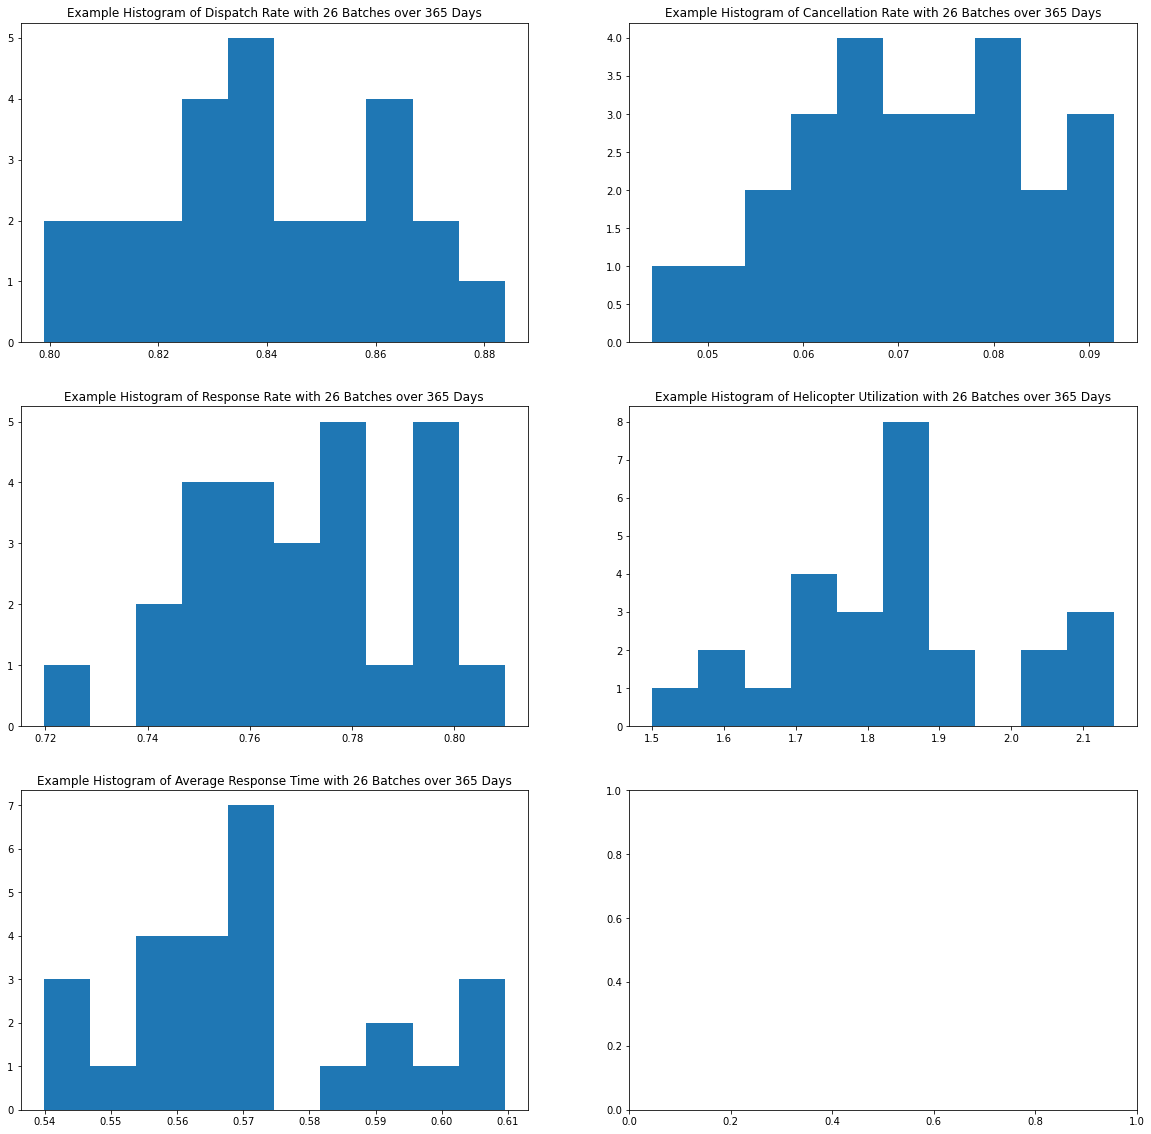

In [55]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

dispatch_rate = example[2][0]
axs[0, 0].hist(dispatch_rate)
axs[0, 0].set_title("Example Histogram of Dispatch Rate with 26 Batches over 365 Days")

cancel_rate = example[2][1]
axs[0, 1].hist(cancel_rate)
axs[0, 1].set_title("Example Histogram of Cancellation Rate with 26 Batches over 365 Days")

response_rate = example[2][2]
axs[1, 0].hist(response_rate)
axs[1, 0].set_title("Example Histogram of Response Rate with 26 Batches over 365 Days")

heli_util = example[2][3]
axs[1, 1].hist(heli_util)
axs[1, 1].set_title("Example Histogram of Helicopter Utilization with 26 Batches over 365 Days")

avg_response_time = example[2][4]
axs[2, 0].hist(avg_response_time)
axs[2, 0].set_title("Example Histogram of Average Response Time with 26 Batches over 365 Days")

We can see that the batch means are approximately normally distributed

## Find Warmup Length

In [56]:
base_locs = [
    [41.979, 76.5155],
    [42.6526, 73.7562],
    [43.0481, 76.1474],
    [43.1566, 77.6088],
    [42.0898, 76.8077],
    [42.0987, 75.918],
    [42.444, 76.5019],
    [42.8864, 78.8784],
    [43.1009, 75.2327],
    [43.9748, 75.9108]
]

x = []

dr = []
cr = []
rr = []
hu = []
art = []

# Experiment warmup lengths between 0 hours and 500 hours every 2 hours for an end time of 365 days for 1 batch 
for i in range(1001):
    if (i in [0, 1, 2, 3, 4, 5, 10, 25, 50, 75, 100, 500, 1000]):
        x.append(i)
        run = simulate(base_locs, 365*24 + i, i, 1, 0.975)
        rates = run[0]
        idx = 0
        for rate_list in [dr, cr, rr, hu, art]:
            rate_list.append(rates[idx][1])
            idx += 1

Text(0.5, 1.0, 'Average Response Time Based on Warmup Length')

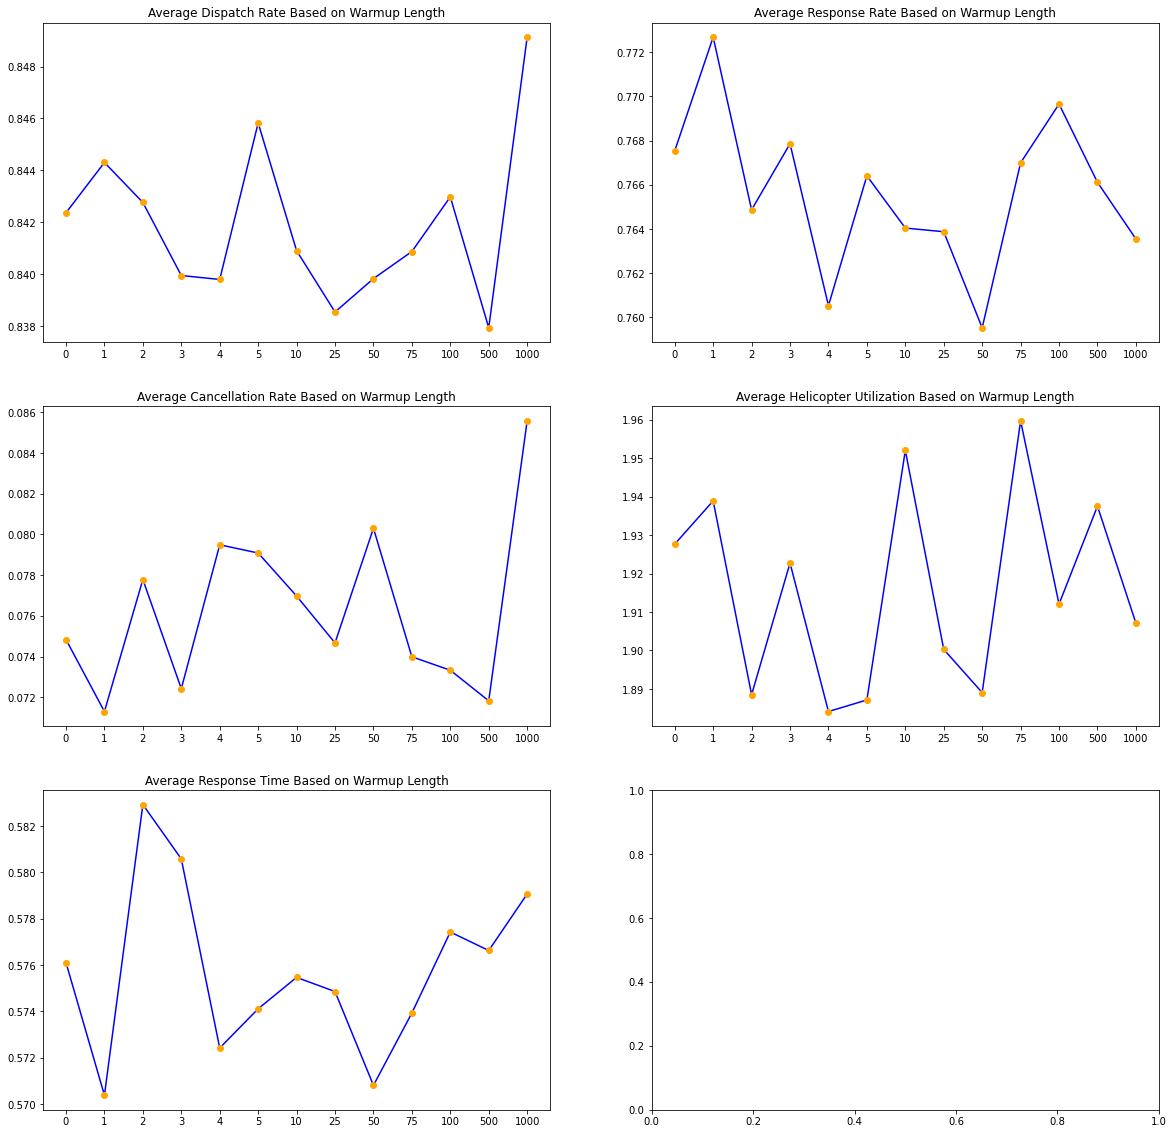

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))

a = np.arange((len(x)))

axes[0,0].plot(a, dr, 'b-') 
axes[0,0].plot(a, dr, 'o', color='orange') 
axes[0,0].xaxis.set_ticks(a)
axes[0,0].xaxis.set_ticklabels(x)
axes[0,0].set_title("Average Dispatch Rate Based on Warmup Length")

axes[0,1].plot(a, rr, 'b-')   
axes[0,1].plot(a, rr, 'o', color='orange') 
axes[0,1].xaxis.set_ticks(range(len(x)))
axes[0,1].xaxis.set_ticklabels(x)
axes[0,1].set_title("Average Response Rate Based on Warmup Length")

axes[1,0].plot(a, cr, 'b-')
axes[1,0].plot(a, cr, 'o', color='orange') 
axes[1,0].xaxis.set_ticks(a)
axes[1,0].xaxis.set_ticklabels(x)
axes[1,0].set_title("Average Cancellation Rate Based on Warmup Length")

axes[1,1].plot(a, hu, 'b-')
axes[1,1].plot(a, hu, 'o', color='orange') 
axes[1,1].xaxis.set_ticks(a)
axes[1,1].xaxis.set_ticklabels(x)
axes[1,1].set_title("Average Helicopter Utilization Based on Warmup Length")

axes[2,0].plot(a, art, 'b-')
axes[2,0].plot(a, art, 'o', color='orange') 
axes[2,0].xaxis.set_ticks(a)
axes[2,0].xaxis.set_ticklabels(x)
axes[2,0].set_title("Average Response Time Based on Warmup Length")

The warmup does not significantly affect the output of the data, past the first 75 hours. So, we set the warmup length to 75 hours to be conservative

## Find Optimal Locations Within Call Data

### Find high probability call locations from data

In [58]:
# Same as the project data homework
# Creates a list of lists that contains the counts/probabilities of a call occuring in that index 
# Indices of the list of lists corresponds to a certain latitude and longitude 
min_lat, max_lat = math.floor(min(df_lat)), math.ceil(max(df_lat))
min_lon, max_lon = math.floor(min(df_lon)), math.ceil(max(df_lon))

lat_bins = np.linspace(min_lat,max_lat,(max_lat - min_lat)*10)
lon_bins = np.linspace(min_lon, max_lon,(max_lon - min_lon)*10)
lat_bins_size = lat_bins[1] - lat_bins[0]
lon_bins_size = lon_bins[1] - lon_bins[0]

counts = np.zeros([len(lat_bins)-1, len(lon_bins)-1])
for i in range(len(df_lat)):
    lat = df_lat[i]
    lon = df_lon[i]
    for x in range(len(lat_bins)-1):
        for y in range(len(lon_bins)-1):
            if lat >= lat_bins[x] and lat < lat_bins[x+1] and lon >= lon_bins[y] and lon < lon_bins[y + 1]: 
                counts[x][y] += 1

total = sum(sum(counts))
probs = counts/total

In [59]:
# finds x and y indices in the probs list of lists, that correspond to a probability of >= 0.015
index = []
for x in range(len(probs)):
    for y in range(len(probs[x])):
        if (probs[x][y] >= 0.015): #gives me 8 locations
            index.append((x,y, probs[x][y]))
index = sorted(index, key=lambda item: item[2], reverse = True)

### Latitude and longitudes of call locations with a probability >= 0.015
This outputs 8 locations

In [60]:
# Generate a list of longitude and latitudes that have a probability of >= 0.015 
lat_lon = []
lat_lon_probs = []
for x, y, probs in index:
    lat = lat_bins[x] + np.random.uniform(0, lat_bins_size)
    lon = lon_bins[y] + np.random.uniform(0, lon_bins_size)
    lat_lon.append([lat, lon])
    lat_lon_probs.append([lat, lon, probs])

In [61]:
lat_lon_probs

[[42.088817634855644, 76.77376053593315, 0.023949629280922678],
 [42.48770343976498, 76.50285123678472, 0.017064846416382253],
 [43.10869093163745, 75.19817644249056, 0.017006002118394727],
 [43.88738494712489, 75.93245201108583, 0.016476403436507],
 [42.89760008036448, 78.85877673750723, 0.01641755913851948],
 [44.01985343214066, 75.91076908530538, 0.016123337648581853],
 [43.09143559122331, 75.31899113929558, 0.015652583264681653],
 [42.42045121429573, 76.4822132717394, 0.015122984582793927]]

## Find Optimal Helicopter Locations and Number of Helicopters

In [62]:
def get_response_time(s_result):
    response_time = (s_result[0][4][1][0]+s_result[0][4][1][1])/2

    return response_time

In [63]:
def get_cancel_rate(s_result):
    p1 = s_result[0][0][1][1][0]
    p2 = s_result[0][0][1][1][1]
    cancel_rate = (p1+p2)/2
    
    return cancel_rate

In [64]:
def find_bases(num_helis,bases):
    combos = []
    for i in combinations_with_replacement(bases,num_helis):
        combos.append(i)
    return combos

In [65]:
#Running simulation
def shortest_responses(num_helis,bases):
    list_results = []
    possible_base_locs = find_bases(num_helis,bases)
    
    for bases in possible_base_locs:
        sim = simulate(bases, 365*24 + 10, 10, round((365*24)/(14*24)), 0.975)
        score = get_response_time(sim)
        list_results.append((sim,score))

    
    sorted_results= sorted(list_results, key=lambda item: item[1])
    
    return sorted_results[:5]

In [66]:
def smallest_cancelation(five_shortest):
    opt_rate = 1
    opt_indx = 0
    for i in range(len(five_shortest)):
        temp = get_cancel_rate(five_shortest[i])
        if temp < opt_rate:
            opt_rate = temp
            opt_indx = i
    return five_shortest[i]

In [67]:
#Takes in number of helicopters and the bases. First finds the 5 base location distributions with the lowest 
    #response times, and then finds the one base location with the lowest cancel_rate
def get_opt_bases(num_helis,bases):
    shortest_five = shortest_responses(num_helis,bases)
    opt = smallest_cancelation(shortest_five)
    opt_return = [('Number of helis:',num_helis),
                opt[0][0][0],
                opt[0][0][1],
                opt[0][0][2],
                opt[0][0][3],
                opt[0][0][4]
                ],opt[0][1]
    return opt_return

In [68]:
nums = np.arange(5,13,1)
print(nums)

[ 5  6  7  8  9 10 11 12]


In [69]:
#Make Dataframe to see the most dense hospitals
count = df.pivot_table(columns=['Hosp lat'], aggfunc='size')
print(count)

Hosp lat
0.0000     4540
41.9790     558
42.0898     622
42.0987    1163
42.4440     630
42.6526    2431
42.8864    1329
43.0481    2020
43.1009     861
43.1566    2035
43.9748     805
dtype: int64


In [70]:
#5 most visited hospital locations from test data
dense_locations = [
    [42.6526, 73.7562],
    [43.1566, 77.6088],
    [43.0481, 76.1474],
    [42.8864, 78.8784],
    [42.0987, 75.918]]

In [71]:
#Warning this takes about an hour and a half to run
bases_five_to_twelve = []
for i in nums:
    val = get_opt_bases(i,dense_locations)
    bases_five_to_twelve.append(val)

In [72]:
for i in range(7):
    print("Optimal Placement For", i, "Helicopters:")
    print(bases_five_to_twelve[i][1])

Optimal Placement For 0 Helicopters:
   HeliAvail  NumTransported                Base
0   0.769231      523.884615  (42.6526, 73.7562)
1   0.615385      803.846154  (43.0481, 76.1474)
2   0.730769      473.000000  (43.0481, 76.1474)
3   0.807692      541.807692   (42.0987, 75.918)
4   0.807692      285.500000   (42.0987, 75.918)
Optimal Placement For 1 Helicopters:
   HeliAvail  NumTransported                Base
0   0.769231      543.038462  (42.6526, 73.7562)
1   0.653846      789.000000  (43.0481, 76.1474)
2   0.807692      452.192308  (43.0481, 76.1474)
3   0.884615      282.384615  (43.0481, 76.1474)
4   0.730769      527.115385   (42.0987, 75.918)
5   0.884615      253.961538   (42.0987, 75.918)
Optimal Placement For 2 Helicopters:
   HeliAvail  NumTransported                Base
0   0.884615      493.576923  (42.6526, 73.7562)
1   0.769231      468.346154  (43.1566, 77.6088)
2   0.846154      215.192308  (43.1566, 77.6088)
3   0.846154      775.961538  (43.0481, 76.1474)
4   0.8

In [73]:
for i in bases_five_to_twelve:
    bss = i[1]['Base'].tolist()
    lat_vals = []
    lon_vals = []
    for j in bss:
        lat_vals.append(j[0])
        lon_vals.append(j[1])
    i[1]['Lon'] = lon_vals
    i[1]['Lat'] = lat_vals  

In [74]:
def make_heat_map(labl,data):
    lat_lon = data[['Lon','Lat']]

    lat_max = math.ceil(np.array(lat_lon['Lat']).max())
    lat_min = math.floor(np.array(lat_lon['Lat']).min())
    lon_max = math.ceil(np.array(lat_lon['Lon']).max())
    lon_min = math.floor(np.array(lat_lon['Lon']).min())
    
    x_bins = np.linspace(lon_min, lon_max,(lon_max-lon_min)*7)
    y_bins = np.linspace(lat_min,lat_max,(lat_max-lat_min)*7)

    plt.hist2d(lat_lon['Lon'],lat_lon['Lat'], bins=(x_bins, y_bins),cmap = plt.cm.jet)
    plt.axis([lon_max,lon_min,lat_min,lat_max])
    x_range = np.arange(math.floor(min(lat_lon['Lon'])), math.ceil(max(lat_lon['Lon'])), 1)
    y_range = np.arange(math.floor(min(lat_lon['Lat'])), math.ceil(max(lat_lon['Lat'])), 1)
    plt.xticks(np.flip(x_range))
    plt.yticks(y_range)
    plt.title(labl)

    plt.colorbar()
    plt.tight_layout()
    plt.show()

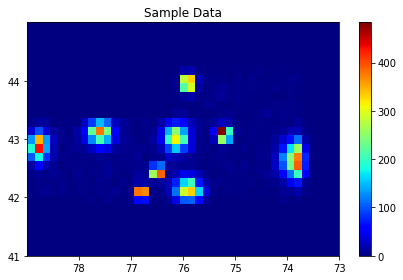

In [75]:
#Heat map of sample data, showing most commonly visited hospitals
make_heat_map("Sample Data",df)

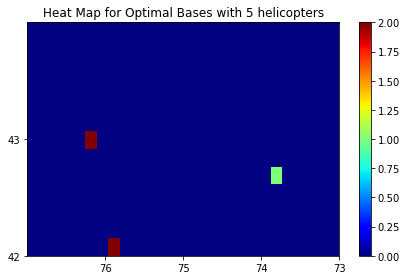

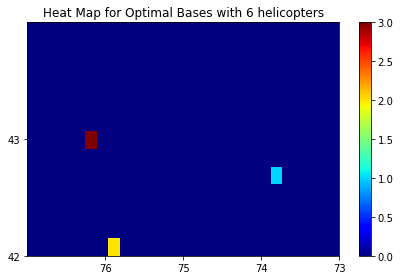

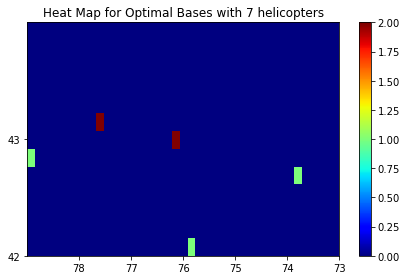

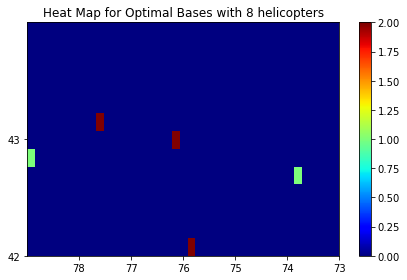

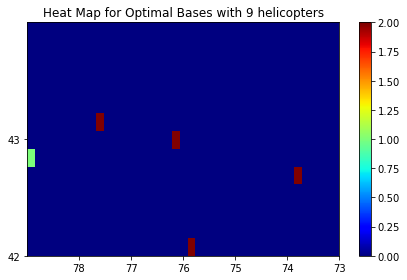

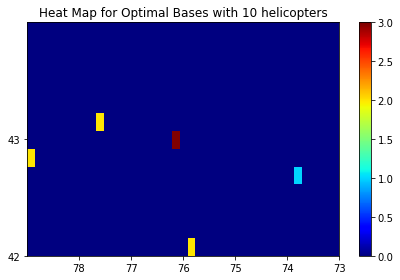

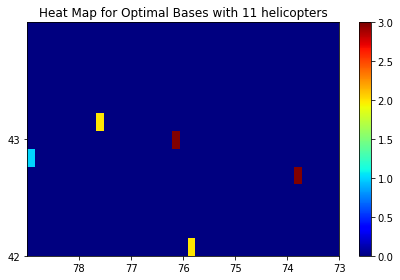

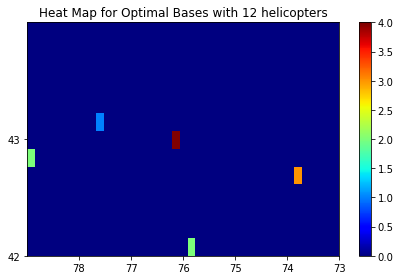

In [76]:
#Heat map for the optimal helicopter locations for iterations with 5,6,7,8,9,10,11,12 helicopters
for i in range(len(bases_five_to_twelve)):
    df = bases_five_to_twelve[i][1]
    name = "Heat Map for Optimal Bases with " + str(i+5) + " helicopters" 
    make_heat_map(name,df)

In [77]:
nh = []; dr = []; cr = []; rr = []; uti = []; rt = []
for i in range(len(bases_five_to_twelve)):
    dt = bases_five_to_twelve[i][0]
    nh.append(dt[0][1])
    dr.append((dt[1][1][0]+dt[1][1][1])/2)
    cr.append((dt[2][1][0]+dt[2][1][1])/2)
    rr.append((dt[3][1][0]+dt[3][1][1])/2)
    uti.append((dt[4][1][0]+dt[4][1][1])/2)
    rt.append((dt[5][1][0]+dt[5][1][1])/2)
stats = {'Numbrt of Helicopters': nh,
         'Dispatch Rate' : dr,
         'Cancelation Rate': cr,
         'Response Rate': rr,
         'Utilization': uti,
         'Average Response Time': rt}
stats = pd.DataFrame(stats)
#stats.head()

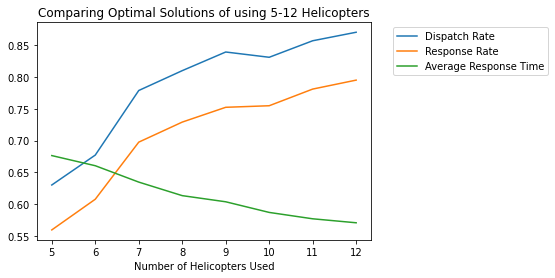

In [78]:
x = stats['Numbrt of Helicopters']; y1 = stats['Dispatch Rate']; y2 = stats['Cancelation Rate']; y3 = stats['Response Rate']; y4 = stats['Utilization']; y5 = stats['Average Response Time']
plt.plot(x,y1, label = "Dispatch Rate")
plt.plot(x,y3, label = "Response Rate")
plt.plot(x,y5, label = 'Average Response Time')
plt.legend(bbox_to_anchor=(1.05,1.0),loc = 'upper left')
plt.title('Comparing Optimal Solutions of using 5-12 Helicopters')
plt.xlabel('Number of Helicopters Used')
plt.show()

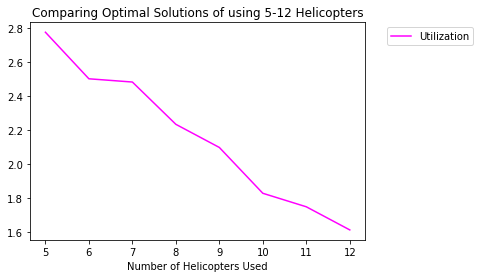

In [119]:
plt.plot(x,y4, label = "Utilization",color="Magenta")
plt.legend(bbox_to_anchor=(1.05,1.0),loc = 'upper left')
plt.title('Comparing Optimal Solutions of using 5-12 Helicopters')
plt.xlabel('Number of Helicopters Used')
plt.show()

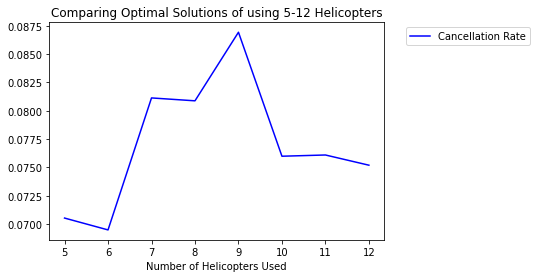

In [124]:
plt.title('Comparing Optimal Solutions of using 5-12 Helicopters')
plt.xlabel('Number of Helicopters Used')
plt.plot(x,y2, label = "Cancellation Rate",color='Blue')
plt.legend(bbox_to_anchor=(1.05,1.0),loc = 'upper left')
plt.show()

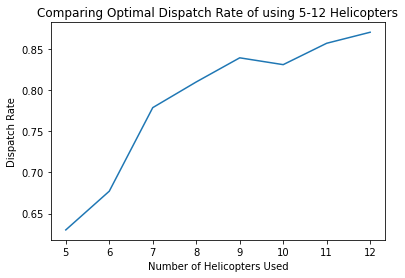

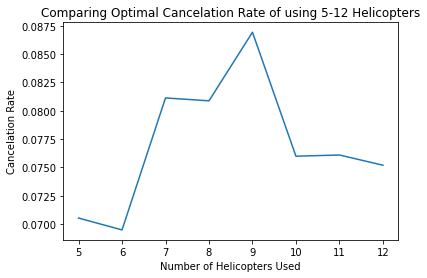

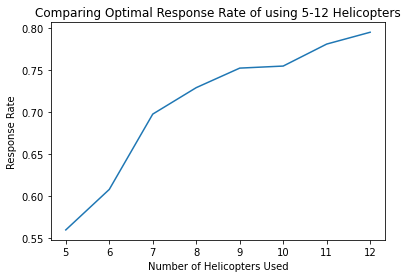

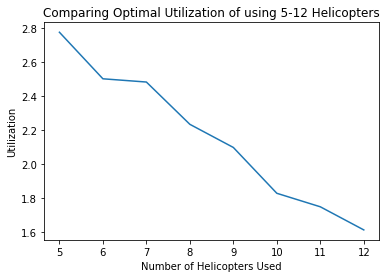

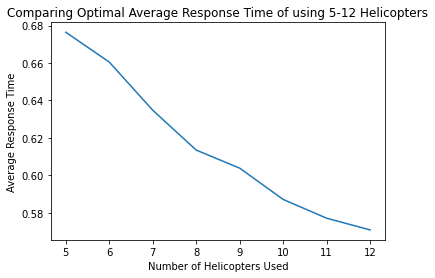

In [80]:
y_title = ['Dispatch Rate','Cancelation Rate','Response Rate','Utilization','Average Response Time']
for i in y_title:
    y = stats[i]
    plt.plot(x,y)
    ttl = 'Comparing Optimal '+ i + ' of using 5-12 Helicopters'
    plt.title(ttl)
    plt.xlabel('Number of Helicopters Used')
    plt.ylabel(i)
    plt.show()

## Testing Optimal Bases for 10 Helicopters

In [81]:
optimal10 = bases_five_to_twelve[5]
optimal10_bases = optimal10[1]['Base'].tolist()
optimal10_bases_plus = optimal10_bases
optimal10_bases_plus.extend([(43.9748, 75.9108)])
optimal10_plus = simulate(optimal10_bases_plus, 365*24 + 10, 10, round((365*24)/(14*24)), 0.975)
optimal10_plus = [('Number of helis:',11),
                optimal10_plus[0][0],
                optimal10_plus[0][1],
                optimal10_plus[0][2],
                optimal10_plus[0][3],
                optimal10_plus[0][4]
                ],optimal10_plus[1]

In [82]:
def get_stats(dt):
    empty = []
    empty.append(int(dt[0][1]))
    empty.append((dt[1][1][0]+dt[1][1][1])/2)
    empty.append((dt[2][1][0]+dt[2][1][1])/2)
    empty.append((dt[3][1][0]+dt[3][1][1])/2)
    empty.append((dt[4][1][0]+dt[4][1][1])/2)
    empty.append((dt[5][1][0]+dt[5][1][1])/2)
    return empty

In [83]:
optimal10[1]

,HeliAvail,NumTransported,Base,Lon,Lat
0,0.692308,486.807692,"(42.6526, 73.7562)",73.7562,42.6526
1,0.884615,395.538462,"(43.1566, 77.6088)",77.6088,43.1566
2,0.884615,139.923077,"(43.1566, 77.6088)",77.6088,43.1566
3,0.461538,715.307692,"(43.0481, 76.1474)",76.1474,43.0481
4,0.807692,362.153846,"(43.0481, 76.1474)",76.1474,43.0481
5,0.961538,175.269231,"(43.0481, 76.1474)",76.1474,43.0481
6,0.730769,366.730769,"(42.8864, 78.8784)",78.8784,42.8864
7,0.884615,109.230769,"(42.8864, 78.8784)",78.8784,42.8864
8,0.923077,467.615385,"(42.0987, 75.918)",75.9180,42.0987
9,0.961538,191.038462,"(42.0987, 75.918)",75.9180,42.0987


In [84]:
optimal10_plus[1]

,HeliAvail,NumTransported,Base
0,0.846154,499.500000,"(42.6526, 73.7562)"
1,0.807692,368.346154,"(43.1566, 77.6088)"
2,0.923077,115.423077,"(43.1566, 77.6088)"
3,0.692308,689.884615,"(43.0481, 76.1474)"
4,0.923077,343.192308,"(43.0481, 76.1474)"
5,0.923077,144.115385,"(43.0481, 76.1474)"
6,0.846154,353.923077,"(42.8864, 78.8784)"
7,0.923077,96.807692,"(42.8864, 78.8784)"
8,0.846154,451.692308,"(42.0987, 75.918)"
9,1.000000,174.923077,"(42.0987, 75.918)"


In [85]:
stats_names = ["Number of Helicopter","Dispatch Rate","Cancelation Rate","Response Rate","Utilization",'Average Response Time']
optimal10_stats = get_stats(optimal10[0])
optimal10_plus_stats = get_stats(optimal10_plus[0])
optimal_compare = pd.DataFrame({"":stats_names, "Optimal Helicopters": optimal10_stats, "Optimal Helicopters Plus Additional Base":optimal10_plus_stats})
optimal_compare

,,Optimal Helicopters,Optimal Helicopters Plus Additional Base
0,Number of Helicopter,10.000000,11.000000
1,Dispatch Rate,0.830742,0.839286
2,Cancelation Rate,0.075988,0.077818
3,Response Rate,0.754656,0.761459
4,Utilization,1.828219,1.654795
5,Average Response Time,0.587161,0.568516


# Sensitivity Analysis

In [102]:
#Optimal placement for 5 and 12 helicopters from above:

#Overall optimal solution; uses 11 helicopters
optimal_base_locs= [
    [42.6526, 73.7562],
    [42.6526, 73.7562],
    [43.1566, 77.6088],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [42.8864, 78.8784],
    [42.8864, 78.8784],
    [42.0987, 75.918],
    [43.9748, 75.9108],
]

#Optimal solution for 5 helicopters
optimal_5_base_locs= [
    [42.6526, 73.7562],
    [43.1566, 77.6088],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [42.0987, 75.918],
]

#Optimal solution for 12 helicopters
optimal_12_base_locs= [
    [42.6526, 73.7562],
    [42.6526, 73.7562],
    [42.6526, 73.7562],
    [43.1566, 77.6088],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [43.0481, 76.1474],
    [42.8864, 78.8784],
    [42.8864, 78.8784],
    [42.0987, 75.918],
    [42.0987, 75.918],
]

### Changing Call Arrival Rate

In [103]:
#Original with 12 helicopters optimally assigned from above
original_12= simulate(optimal_12_base_locs, 365*24+10, 10, 26, 0.975)
original_5= simulate(optimal_5_base_locs, 365*24+10, 10, 26, 0.975)
original_= simulate(optimal_base_locs, 365*24+10, 10, 26, 0.975)

#decrease call rates by 20%
for i in range(24):
    val= call_rates[i+1]
    call_rates.update({i+1:val*0.8})
increase_12_arr_20= simulate(optimal_12_base_locs, 365*24+10, 10, 26, 0.975)
increase_5_arr_20= simulate(optimal_5_base_locs, 365*24+10, 10, 26, 0.975)
increase_opt_arr_20= simulate(optimal_base_locs, 365*24+10, 10, 26, 0.975)

#Increase call rates by 20%
for i in range(24):
    val= call_rates[i+1]
    call_rates.update({i+1:val*1.2/0.8})
decrease_12_arr_20= simulate(optimal_12_base_locs, 365*24+10, 10, 26, 0.975)
decrease_5_arr_20= simulate(optimal_5_base_locs, 365*24+10, 10, 26, 0.975)
decrease_opt_arr_20= simulate(optimal_base_locs, 365*24+10, 10, 26, 0.975)

#Reset call rates
for i in range(24):
    val= call_rates[i+1]
    call_rates.update({i+1:val/1.2})

#### With Optimal Solution of 11 Helicopters

In [105]:
original_[0]

[('Dispatch Rate', [0.8544704590694735, 0.8585193622186452]),
 ('Cancel Rate', [0.0757923522126493, 0.07737272932596548]),
 ('Response Rate', [0.7779465163382413, 0.78221686894884]),
 ('Utilization of Helicopters', [1.7408067505933886, 1.7690313565049929]),
 ('Average Response Time', [0.5689976199833628, 0.5717254981504474])]

In [106]:
increase_opt_arr_20[0]

[('Dispatch Rate', [0.8365750608005669, 0.8390705477789095]),
 ('Cancel Rate', [0.0753520927655983, 0.07712461800162539]),
 ('Response Rate', [0.759719523231184, 0.7634821618517049]),
 ('Utilization of Helicopters', [2.2325772668639527, 2.2565883620277014]),
 ('Average Response Time', [0.5891871582860956, 0.5914874206338158])]

In [107]:
decrease_opt_arr_20[0]

[('Dispatch Rate', [0.8606989657769198, 0.8632957977029169]),
 ('Cancel Rate', [0.0696222670688757, 0.07185614597752504]),
 ('Response Rate', [0.7896903127972178, 0.792873720341769]),
 ('Utilization of Helicopters', [1.414675263022556, 1.4311528814357253]),
 ('Average Response Time', [0.5618066645445955, 0.5645414575306434])]

#### With 12 Helicopters

In [108]:
original_12[0]

[('Dispatch Rate', [0.8635679514059419, 0.8667545628621148]),
 ('Cancel Rate', [0.07537500646435287, 0.07707780350324044]),
 ('Response Rate', [0.7872825675630599, 0.7904365942843401]),
 ('Utilization of Helicopters', [1.6104903199405514, 1.6315188124795408]),
 ('Average Response Time', [0.5693380436183493, 0.570995400152988])]

In [109]:
increase_12_arr_20[0]

[('Dispatch Rate', [0.8504046049704271, 0.8529696185073724]),
 ('Cancel Rate', [0.08195743304390367, 0.08405450625613732]),
 ('Response Rate', [0.7670708229548776, 0.7701963859618407]),
 ('Utilization of Helicopters', [2.0024112545297768, 2.0204197956985337]),
 ('Average Response Time', [0.5818145692220535, 0.5843255040333886])]

In [110]:
decrease_12_arr_20[0]

[('Dispatch Rate', [0.8738299815243262, 0.8763893443826734]),
 ('Cancel Rate', [0.07848685557089098, 0.08106036008159843]),
 ('Response Rate', [0.7939084550755392, 0.7968003963631946]),
 ('Utilization of Helicopters', [1.3344796461309665, 1.3504518607183487]),
 ('Average Response Time', [0.5711426020934655, 0.5736021968949937])]

#### With 5 helicopters

In [111]:
original_5[0]

[('Dispatch Rate', [0.6674729845176479, 0.6714721538676007]),
 ('Cancel Rate', [0.07082691435402189, 0.07305931580258668]),
 ('Response Rate', [0.5953908674023741, 0.5999161585251643]),
 ('Utilization of Helicopters', [2.8725734043536635, 2.9104402942764738]),
 ('Average Response Time', [0.6779705018728434, 0.6821605716844591])]

In [112]:
increase_5_arr_20[0]

[('Dispatch Rate', [0.6274199659090585, 0.6318211614316269]),
 ('Cancel Rate', [0.07013360762113448, 0.07195750119982962]),
 ('Response Rate', [0.5564639547602879, 0.5606535837716282]),
 ('Utilization of Helicopters', [3.5299377183461087, 3.564856802201836]),
 ('Average Response Time', [0.6864377683244333, 0.6895816363490305])]

In [113]:
decrease_12_arr_20[0]

[('Dispatch Rate', [0.8738299815243262, 0.8763893443826734]),
 ('Cancel Rate', [0.07848685557089098, 0.08106036008159843]),
 ('Response Rate', [0.7939084550755392, 0.7968003963631946]),
 ('Utilization of Helicopters', [1.3344796461309665, 1.3504518607183487]),
 ('Average Response Time', [0.5711426020934655, 0.5736021968949937])]

### Changing Hospital and Scene Times to Beta Distribution with Same Mean and Variance

#### Using optimal solution of 11 helicopters

In [114]:
#Should be using opt helicopters here
#if no params inputted for hosp and scene, we use gamma dist for both
sim_beta_hosp= simulate(optimal_base_locs, 365*24+10, 10, 26, 0.975,hosp="beta")
sim_beta_scene= simulate(optimal_base_locs, 365*24+10, 10, 26, 0.975,scene="beta")
sim_beta_hosp_and_scene= simulate(optimal_base_locs, 365*24+10, 10, 26, 0.975,hosp= "beta",scene="beta")

In [115]:
#Both gamma
original_[0]

[('Dispatch Rate', [0.8544704590694735, 0.8585193622186452]),
 ('Cancel Rate', [0.0757923522126493, 0.07737272932596548]),
 ('Response Rate', [0.7779465163382413, 0.78221686894884]),
 ('Utilization of Helicopters', [1.7408067505933886, 1.7690313565049929]),
 ('Average Response Time', [0.5689976199833628, 0.5717254981504474])]

In [116]:
#Hospital times are beta
sim_beta_hosp[0]

[('Dispatch Rate', [0.8511858513436702, 0.8539834884998881]),
 ('Cancel Rate', [0.07719457013735691, 0.07962614658730278]),
 ('Response Rate', [0.7724326584480843, 0.7758342557357953]),
 ('Utilization of Helicopters', [1.6863046694614292, 1.7099593405012108]),
 ('Average Response Time', [0.5695315610429252, 0.5720663017459082])]

In [117]:
#Scene times are beta
sim_beta_scene[0]

[('Dispatch Rate', [0.85642452449967, 0.8597772764734626]),
 ('Cancel Rate', [0.0741733766486581, 0.07610620660671867]),
 ('Response Rate', [0.7810973929686741, 0.7848052785741545]),
 ('Utilization of Helicopters', [1.688675287972651, 1.7115737780298392]),
 ('Average Response Time', [0.574257437450843, 0.5769365416749835])]

In [118]:
#Hospital and scene times are beta
sim_beta_hosp_and_scene[0]

[('Dispatch Rate', [0.8591308445207747, 0.8621451876540905]),
 ('Cancel Rate', [0.07342642584246034, 0.07594912138207147]),
 ('Response Rate', [0.7839506339678038, 0.7879712515488894]),
 ('Utilization of Helicopters', [1.752310137001422, 1.7724719302463978]),
 ('Average Response Time', [0.573886794249847, 0.5762171172189184])]